In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

df = pd.read_csv('result/data/melting_point_features.csv')

y = df['Tm']
X = df.drop(columns=['Tm'])

X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer = SimpleImputer(strategy='median')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

base_model = LGBMRegressor(random_state=42, n_jobs=1)

Ranking features (Fast Mode)...
Ranking done in 5.2s

Starting MAE Loop (26 steps)...
   -> Top 937 features: MAE = 121.88
   -> Top 887 features: MAE = 122.03
   -> Top 837 features: MAE = 121.26
   -> Top 787 features: MAE = 122.58
   -> Top 737 features: MAE = 121.89
   -> Top 687 features: MAE = 121.97
   -> Top 637 features: MAE = 122.01
   -> Top 587 features: MAE = 121.82
   -> Top 537 features: MAE = 122.06
   -> Top 487 features: MAE = 121.85
   -> Top 437 features: MAE = 122.28
   -> Top 387 features: MAE = 121.87
   -> Top 337 features: MAE = 121.92
   -> Top 287 features: MAE = 122.11
   -> Top 237 features: MAE = 122.09
   -> Top 187 features: MAE = 123.52
   -> Top 137 features: MAE = 124.02
   -> Top  90 features: MAE = 126.34
   -> Top  80 features: MAE = 125.98
   -> Top  70 features: MAE = 126.15
   -> Top  60 features: MAE = 126.79
   -> Top  50 features: MAE = 127.56
   -> Top  40 features: MAE = 130.38
   -> Top  30 features: MAE = 133.30
   -> Top  20 features: MA

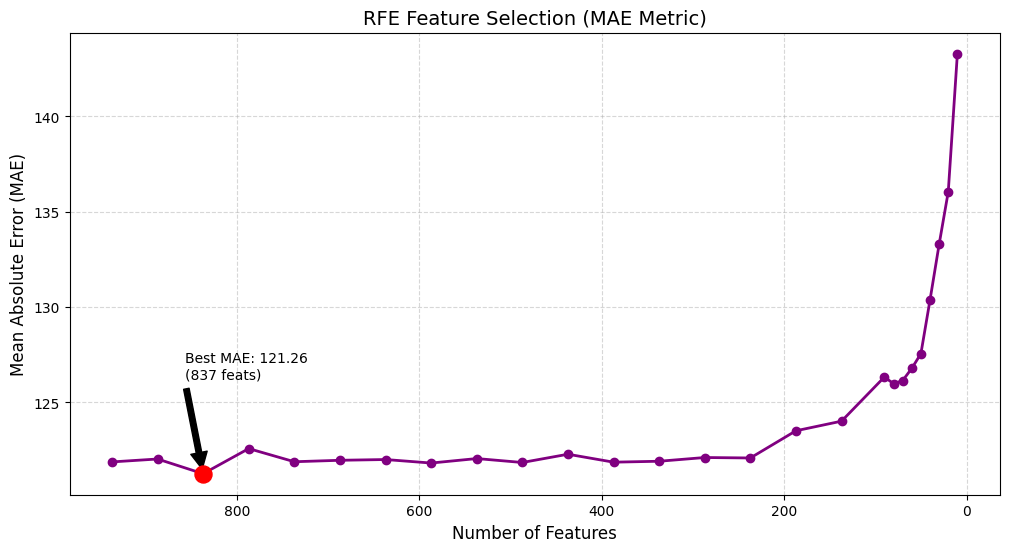


TOP 5 CONFIGURATIONS (LOWEST MAE):
   Num_Features         MAE
0           837  121.262540
1           587  121.822919
2           487  121.851598
3           387  121.868278
4           937  121.881700

LOOP PROGRESS:
    Num_Features         MAE
25            10  143.292576
24            20  136.053997
23            30  133.297208
22            40  130.376021
21            50  127.559067
20            60  126.787221
19            70  126.150454
18            80  125.982987
17            90  126.336405
16           137  124.019467


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFE
import time

best_params = {
    'learning_rate': 0.01,
    'n_estimators': 2000,
    'num_leaves': 50,
    'max_depth': -1,
    'random_state': 2601,
    'n_jobs': 1,
    'verbose': -1
}

fast_params = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'num_leaves': 31,
    'random_state': 2601,
    'n_jobs': -1,
    'verbose': -1
}

print("Ranking features (Fast Mode)...")
start_time = time.time()

rfe_selector = RFE(estimator=LGBMRegressor(**fast_params), 
                   n_features_to_select=1, 
                   step=0.1, 
                   verbose=0)

rfe_selector.fit(X_train, y_train) 

rfe_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Rank': rfe_selector.ranking_
}).sort_values(by='Rank', ascending=True)

sorted_feats = rfe_df['Feature'].tolist()
print(f"Ranking done in {time.time() - start_time:.1f}s")

steps = list(range(len(sorted_feats), 99, -50)) + list(range(90, 0, -10))
results = []

print(f"\nStarting MAE Loop ({len(steps)} steps)...")

for k in steps:
    current_feats = sorted_feats[:k]
    
    model = LGBMRegressor(**best_params)
    model.fit(X_train[current_feats], y_train)
    
    y_pred = model.predict(X_test[current_feats])
    mae = mean_absolute_error(y_test, y_pred)

    print(f"   -> Top {k:3d} features: MAE = {mae:.2f}")
    results.append({'Num_Features': k, 'MAE': mae})

df_results = pd.DataFrame(results).sort_values(by='Num_Features')
df_leaderboard = df_results.sort_values(by='MAE', ascending=True).reset_index(drop=True)

csv_filename = 'rfe_mae_results.csv'
df_results.to_csv(csv_filename, index=False)

plt.figure(figsize=(12, 6))
plt.plot(df_results['Num_Features'], df_results['MAE'], marker='o', linewidth=2, color='purple')

best_row = df_results.loc[df_results['MAE'].idxmin()]
plt.scatter(best_row['Num_Features'], best_row['MAE'], color='red', s=150, zorder=5)
plt.annotate(f"Best MAE: {best_row['MAE']:.2f}\n({int(best_row['Num_Features'])} feats)", 
             (best_row['Num_Features'], best_row['MAE']), 
             xytext=(best_row['Num_Features']+20, best_row['MAE']+5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('RFE Feature Selection (MAE Metric)', fontsize=14)
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().invert_xaxis()
plt.show()

print("\nTOP 5 CONFIGURATIONS (LOWEST MAE):")
print(df_leaderboard.head(5))

print("\nLOOP PROGRESS:")
print(df_results.head(10))